<a href="https://colab.research.google.com/github/mffg1993/TurbulentOptics/blob/main/ZernikePolynomials.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiments on Zernike Polynomials

In [ ]:
# manage the imports
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import threading
from io import StringIO
import sys
import ipywidgets as widgets
import math

In [ ]:

# Coeffcients and powers or the radial Polynomials
def RR(m,n):
  nm=n-m
  coeff=[]
  pow=[]
  if (n-m)%2==0:
    for kk in range(0,int((n-m)/2+1)):
      aa=((-1)**kk*math.factorial(n-kk))/(math.factorial(kk)*math.factorial((n+m)/2-kk)*math.factorial((n-m)/2-kk))
      bb=n-2*kk
      coeff.append(aa)
      pow.append(bb)
  else:
    coeff.append(0)
    pow.append(0)
  return([coeff,pow])

# Construction of the polynomial
def Zernike(RHO,PHI,m,n):
  ZR=np.zeros(RHO.shape);
  rn=RR(np.abs(m),n)

  for ii in range(len(rn[0])):
    ZR=ZR+rn[0][ii]*RHO**rn[1][ii]

  if m>=0:
    Z=ZR*np.cos(np.abs(m)*PHI)
  else:
    Z=ZR*np.sin(np.abs(m)*PHI)
  M=(RHO<=1)
  P=Z*M
  P=(P-np.min(P))/np.max(P-np.min(P))
  return(P)


# Laguerre Polynomials
def NlaguerreL(n,a,X):
  LL=0
  for m in range(n+1):
    LL=LL+((-1)**m)*(math.factorial(n+a))/(math.factorial(n-m)*math.factorial(a+m)*math.factorial(m))*(X**m);
  return(LL)

# Laguerre-Gaussian Beam where ell and p are the azimuthal and radial indexes
def LG(RHO,PHI,ell,p,w0):
  C=np.sqrt((2*math.factorial(p))/(np.pi*math.factorial(p+np.abs(ell))))
  return(C*np.exp(-(RHO/w0)**2)*((np.sqrt(2)*RHO/w0)**np.abs(ell))*np.exp(1j*ell*PHI)*NlaguerreL(p,np.abs(ell),2*(RHO/w0)**2))


# Fresnel propagation
def propTF(u1,L,la,z):
  M,nn=u1.shape
  dx=L/M
  fx=np.arange(-1/(2*dx),1/(2*dx),1/L)
  Fx, Fy = np.meshgrid(fx, fx)

  H=np.exp(-1j*np.pi*0.25*la*z*(Fx**2+Fy**2))

  U2=H*np.fft.fftshift(np.fft.fft2(u1))

  u2=np.fft.ifft2(np.fft.ifftshift(U2))
  return u2

#Fraunhofer propagation
def propFF(u1,L1,la,z):
  M,nn=u1.shape
  dx1=L1/M
  k=2*np.pi/la
  L2=la*z/dx1
  dx2=la*z/L1
  x2=np.arange(-L2/2,L2/2,dx2)
  X2,Y2=np.meshgrid(x2,x2);
  #c=1/(1j*la*z)*np.exp(1j*k/(2*z)*(X2**2+Y2**2))
  u2=np.fft.fftshift(np.fft.fft2(np.fft.fftshift(u1)))*dx1**2
  return [u2,L2,X2,Y2]




# Cartesian to Polar coordinates
def cart2pol(x, y):
  rho = np.sqrt(x**2 + y**2)
  phi = np.arctan2(y, x)
  return(rho, phi)

k=2*np.pi  # [m^-1] wavenumber         # [mm] beam waist
maxx=3       # [units of w0] Half length of the numerical window
N=512         # [Number of points per dimension]
                # For fast results, consider using an square matrix and N to be a power of 2

# Space definition
X=np.linspace(-maxx,maxx,N);
Y=-np.linspace(-maxx,maxx,N);


h=np.abs(X[1]-X[2]);
xx,yy=np.meshgrid(X,Y);
r, phi= cart2pol(xx,yy)



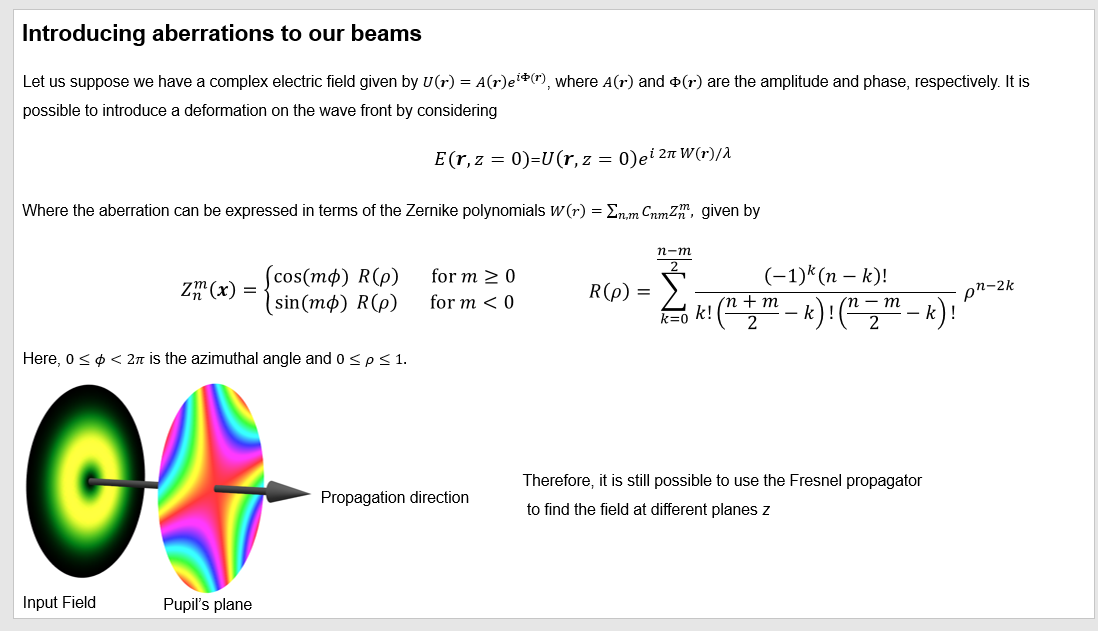

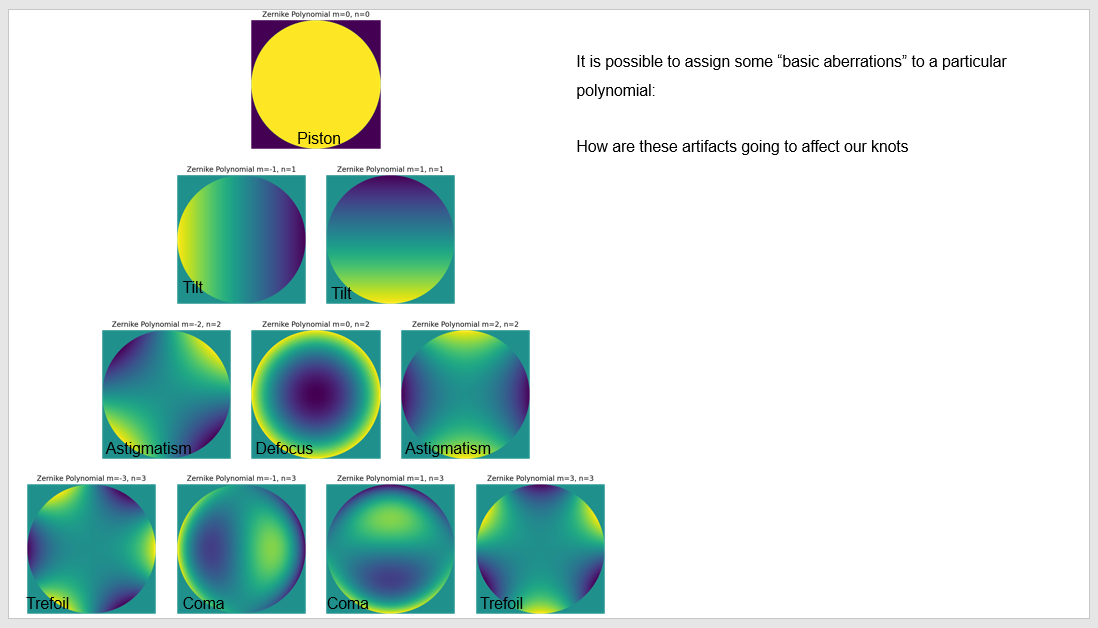

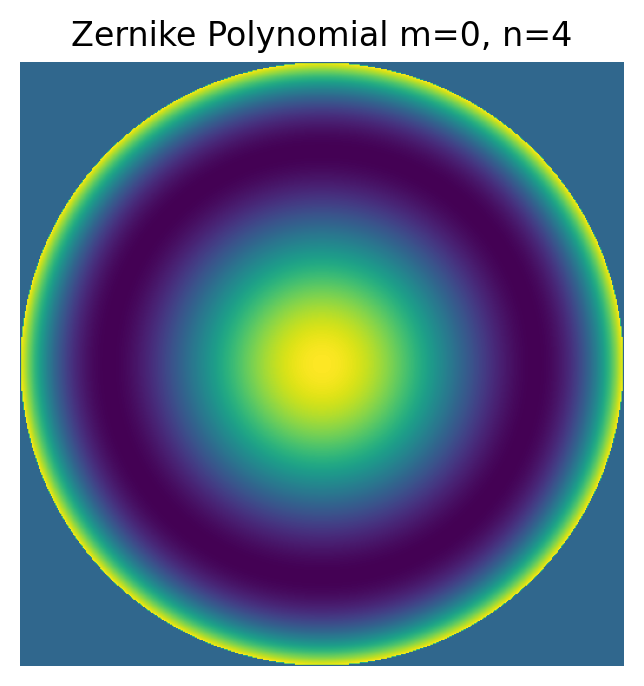

In [ ]:
# Introducing astigmatism
m=0
n=4
P=Zernike(r/3,np.transpose(phi),m,n)

plt.figure(figsize=(4,4),dpi=200)
plt.title('Zernike Polynomial m='+str(m)+', n='+str(n))
plt.imshow(P)
plt.axis('off')
#plt.colorbar()
plt.show()


In [ ]:
rs=r
A=LG(r,phi,1,0,0.25)
plt.figure(figsize=(5,5),dpi=5)
plt.subplot(121)
plt.imshow(np.abs(A)**2)
plt.title('Amplitude')
plt.axis('off')
plt.subplot(122)
plt.imshow(np.angle(A),cmap='hsv',vmin=-np.pi,vmax=np.pi)
plt.title('Phase')
plt.axis('off')
plt.show()

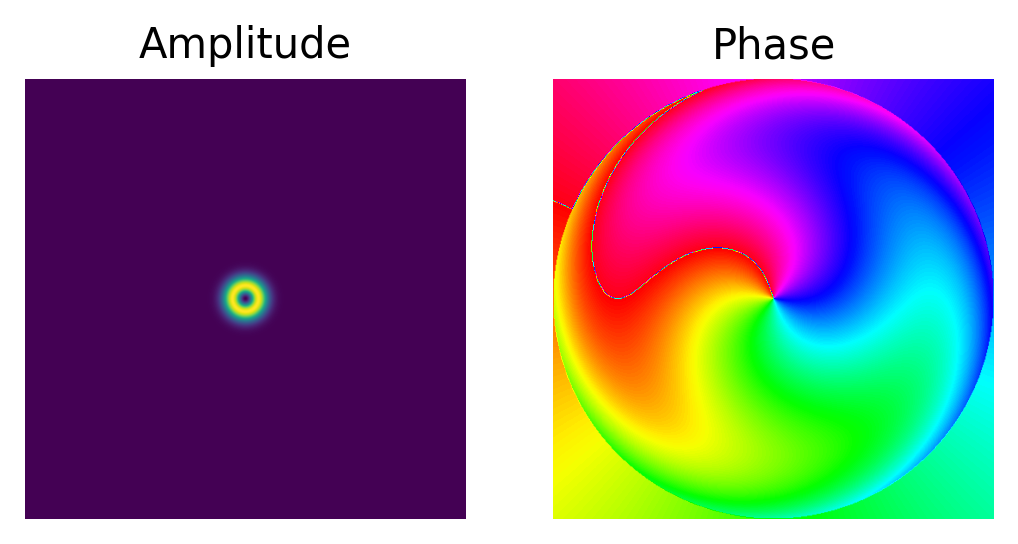

In [ ]:
A1=np.exp(1j*2*np.pi*0.2*P)*A
plt.figure(figsize=(5,5),dpi=250)
plt.subplot(121)
plt.imshow(np.abs(A1)**2)
plt.title('Amplitude')
plt.axis('off')
plt.subplot(122)
plt.imshow(np.angle(A1),cmap='hsv',interpolation='bilinear')
plt.title('Phase')
plt.axis('off')
plt.show()

In [ ]:
Z0=2
nz=150

# Propagation space
Z=np.linspace(0,Z0,nz)

# Propagation steps
dz=np.abs(Z[0]-Z[1])

# Saving the field at every plane
F=[A1]

# Initialization the propagation
U=A1

# Forward Propagation
for ii in range(0,nz):
  U=propTF(U,2*maxx,1,dz) # Field at plane z->z_0
  F.append(U)

In [ ]:
def f(value):
  fig=plt.figure(figsize=(8,8),dpi=200)
  plt.subplot(1,2,1),plt.title('Amplitude'),plt.imshow(np.abs(F[value])**2, cmap='gray')
  plt.subplot(1,2,2),plt.title('Phase'),plt.imshow(np.angle(F[value]), cmap='hsv')

w = widgets.interactive(f, value=widgets.IntSlider(min=0, max=len(F)-1, step=1))

def work(w):
    for ii in range(10):
        time.sleep(0.5)
        print(w.kwargs, w.result)

thread = threading.Thread(target=work, args=(w,))

display(w)

interactive(children=(IntSlider(value=0, description='value', max=150), Output()), _dom_classes=('widget-inter…

# Turbulence

In [ ]:
import numpy as np
from numpy import fft
import time
import random


def ft_phase_screen(r0,Nx,Ny,delta,L0,l0,FFT=None,seed=None):
    R = random.SystemRandom(time.time())
    if seed is None:
        seed = int(R.random()*100000)
    numpy.random.seed(seed)

    del_fx = 1./(Nx*delta)
    del_fy = 1./(Ny*delta)

    FX = numpy.arange(-Nx/2., Nx/2.) * del_fx
    FY = numpy.arange(-Ny/2., Ny/2.) * del_fy

    (fx, fy) = numpy.meshgrid(FX,FY)
    f = numpy.sqrt(fx**2. + fy**2.)

    fm = 5.92/l0/(2*numpy.pi)
    f0 = 1./L0

    PSD_phi  = (0.023*r0**(-5./3.) * np.exp(-1*((f/fm)**2)) /
                ( ( (f**2) + (f0**2) )**(11./6) ) )

    PSD_phi[int(N/2),int(N/2)] = 0

    cn=(np.random.normal(size=(Ny,Nx))+1j*np.random.normal(size=(Ny,Nx)))*np.sqrt(PSD_phi*del_fx*del_fy)

    phs = ift2(cn,1, FFT).real

    return(phs)


def ift2(G, delta_f ,FFT=None):

    N = G.shape[0]

    if FFT:
        g = numpy.fft.fftshift( FFT( numpy.fft.fftshift(G) ) ) * (N * delta_f)**2
    else:
        print('uno')
        g = fft.ifftshift( fft.ifft2( fft.fftshift(G) ) ) * (N * delta_f)**2

    return g

uno


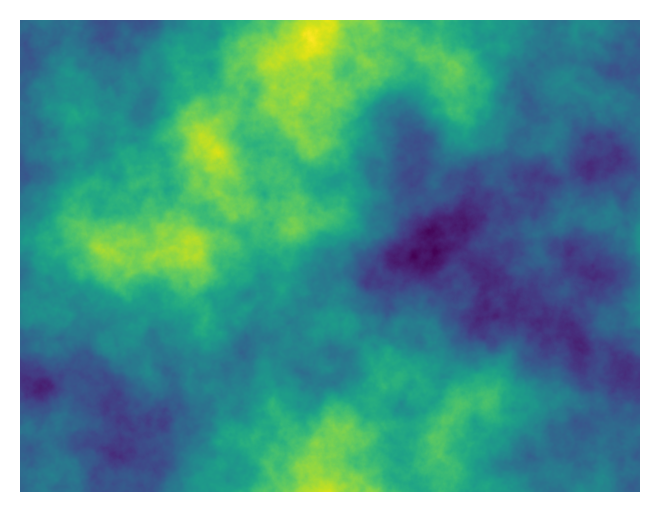

In [ ]:
D = 2; # length of one side of square phase screen [m]
r0 = 0.01; # coherence diameter [m]
Nx = 1024; # number of grid points per side
Ny = 780; # number of grid points per side
L0 = 100; # outer scale [m]
l0 = 0.01; # inner scale [m]
delta = D/N


kk=ft_phase_screen(r0,Nx,Ny,delta,L0,l0)

plt.figure(figsize=(4,4),dpi=200)
plt.imshow(kk)
plt.axis('off')
#plt.colorbar()
plt.show()

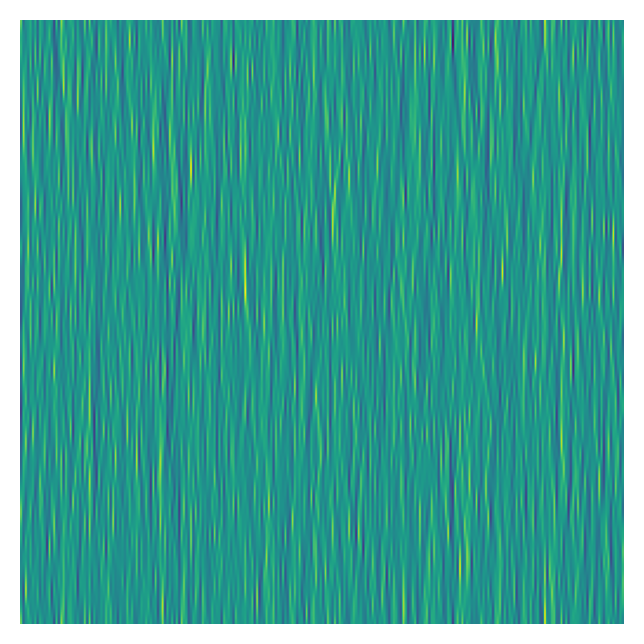

In [ ]:

dx=L/M
fx=np.arange(-1/(2*dx),1/(2*dx),1/L)
Fx, Fy = np.meshgrid(fx, fx)

256

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in power
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


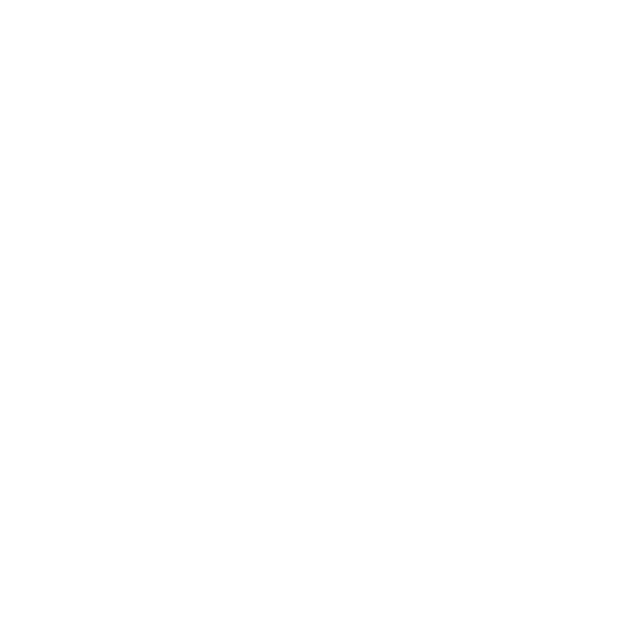

In [ ]:
k=2*np.pi  # [m^-1] wavenumber         # [mm] beam waist
maxx=3       # [units of w0] Half length of the numerical window
N=512         # [Number of points per dimension]
                # For fast results, consider using an square matrix and N to be a power of 2

# Space definition
X=np.linspace(-maxx,maxx,N);
Y=-np.linspace(-maxx,maxx,N);


h=np.abs(X[1]-X[2]);
xx,yy=np.meshgrid(X,Y);
r, phi= cart2pol(xx,yy)


CN2=10**(-15)

## Phase screens
L=2*maxx
dx=L/N
fx=np.arange(-1/(2*dx),1/(2*dx),1/L)
Fx, Fy = np.meshgrid(fx, fx)
th,f=cart2pol(Fx,Fy)

#Kolgomorov
PhiN=0.033*CN2*f**(-11/3)

Phi=(np.random.randn(N,N)+1j*np.random.randn(N,N))*PhiN
Phase=np.real(np.fft.ifftshift(np.fft.ifft2(np.fft.ifftshift(Phi))))


plt.figure(figsize=(4,4),dpi=200)
plt.imshow(Phase)
plt.axis('off')
#plt.colorbar()
plt.show()

In [ ]:
np.random.randn(2,2)

array([[ 0.47680625, -0.63846082],
       [ 0.73676811,  0.14718649]])

In [ ]:
Phase

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [ ]:
import numpy
fx = numpy.arange(-1,2) * 1

In [ ]:
fx

array([-1,  0,  1])

In [ ]:
np.random.normal(size=(5,5))

array([[-0.10868782,  1.14126671,  0.0705715 ,  0.71480918,  1.4897839 ],
       [ 0.88872584,  0.58633952, -1.1471731 , -0.35556512, -0.10064004],
       [ 1.81953985, -0.3699344 , -1.25672748, -0.64396369, -0.832646  ],
       [-0.57660036, -1.13099761, -0.90735275,  0.30731913,  0.72517189],
       [ 0.06909374, -0.08144306,  1.56568555, -0.42430591, -2.34534198]])

In [ ]:
def ft_phase_screen(r0, N, delta, L0, l0, FFT=None, seed=None):
    """
    Creates a random phase screen with Von Karmen statistics.
    (Schmidt 2010)

    Parameters:
        r0 (float): r0 parameter of scrn in metres
        N (int): Size of phase scrn in pxls
        delta (float): size in Metres of each pxl
        L0 (float): Size of outer-scale in metres
        l0 (float): inner scale in metres

    Returns:
        ndarray: numpy array representing phase screen
    """
    delta = float(delta)
    r0 = float(r0)
    L0 = float(L0)
    l0 = float(l0)

    R = random.SystemRandom(time.time())
    if seed is None:
        seed = int(R.random()*100000)
    numpy.random.seed(seed)

    del_f = 1./(N*delta)

    fx = numpy.arange(-N/2., N/2.) * del_f

    (fx, fy) = numpy.meshgrid(fx,fx)
    f = numpy.sqrt(fx**2. + fy**2.)

    fm = 5.92/l0/(2*numpy.pi)
    f0 = 1./L0

    PSD_phi = (0.023*r0**(-5./3.) * numpy.exp(-1*((f/fm)**2)) / (((f**2) + (f0**2))**(11./6)))

    PSD_phi[int(N/2), int(N/2)] = 0

    cn = ((numpy.random.normal(size=(N, N))+1j * numpy.random.normal(size=(N, N))) * numpy.sqrt(PSD_phi)*del_f)

    phs = ift2(cn, 1, FFT).real

    return phs



def ift2(G, delta_f, FFT=None):
    """
    Wrapper for inverse fourier transform

    Parameters:
        G: data to transform
        delta_f: pixel seperation
        FFT (FFT object, optional): An accelerated FFT object
    """

    N = G.shape[0]

    if FFT:
        g = numpy.fft.fftshift(FFT(numpy.fft.fftshift(G))) * (N * delta_f) ** 2
    else:
        g = fft.ifftshift(fft.ifft2(fft.fftshift(G))) * (N * delta_f) ** 2

    return g